# Image segmentation

In [113]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow import keras
from context import geomapi 
# from geomapi.nodes import *
import geomapi.utils as ut
from geomapi.utils import imageutils as iu
import glob
import cv2
import seaborn as sns

## PREPARE DATASET

In [8]:
#MB
projectPath= os.path.join("D:\\Data\\2023-01 Paestum")
imagePath= os.path.join(projectPath,"Research",'Classification_test1','im_temp')
maskPath = os.path.join(projectPath,"Research",'Classification_test1','mask_temp')
modelPath=os.path.join(projectPath,"Research",'Classification_test1',"UNET_segmentation")

# batch_size = 32
# img_height = 224
# img_width = 224
# IMG_SIZE = (img_height, img_width)
#Resizing images, if needed

SIZE_X = 128 
SIZE_Y = 128
# n_classes=13 #Number of classes for segmentation

https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial119_multiclass_semantic_segmentation.ipynb

load images (RGB)

In [9]:
#MB 
image_names = glob.glob(imagePath+'/*.JPG')
image_names.sort()
# RGB IMAGERY -> read all channels
images = [cv2.imread(image) for image in image_names] # why only read first channel? this is for grayscale
# GRAYSCALE IMAGERY -> only read first channel
# images = [cv2.imread(image,0) for image in image_names_subset] 
# rescale images, turn into grayscale and set values to [0-1]
image_dataset=np.array([np.array(tf.cast(tf.image.resize(im, (SIZE_X, SIZE_Y)), tf.float32) / 255.0) for im in images])

load masks (with int values [0,1,2,3, ...])

In [98]:
#MB 
mask_names = glob.glob(maskPath+'/*.JPG')
mask_names.sort()
# 3channel MASK (copied along third axis) -> read all channels else tf cannot resize -> keep only first first channel
masks = [cv2.imread(mask) for mask in mask_names]
mask_dataset=np.array([np.array(tf.cast(tf.image.resize(m, (SIZE_X, SIZE_Y)), tf.int8)) for m in masks])[:,:,:,0]
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3) 
labels,weights=np.unique(mask_dataset_encoded,return_counts=True)
n_classes=len(labels)
colors=[ut.random_color(255) for i in range(n_classes) ]
dic = {i: colors[i] for i in range(n_classes)}

weights=weights/np.max(weights)
class_weights=dic = {i: weights[i] for i in range(n_classes)}

In [99]:
print("Image data shape is: ", image_dataset.shape) # shape should be (n_image, 128,128,1)
print("Mask data shape is: ", mask_dataset_encoded.shape) # shape should be (n_image, 128,128,1)
print("Max pixel value in image is: ", image_dataset.max()) # -> max value should be 1 else normalize
print("Labels in the mask are : ", labels) # -> labels should be [0,1,2,3, ..] else remap
print("n_classes is : ", n_classes) 
print("colors are : ", colors) 
print("weights are : ", class_weights) 

Image data shape is:  (81, 128, 128, 3)
Mask data shape is:  (81, 128, 128, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [ 0  1  2  3  4  5  6  7  8  9 10]
n_classes is :  11
colors are :  [array([113, 158, 102]), array([ 11, 152,  55]), array([ 90,  99, 209]), array([201, 218,  19]), array([170, 140, 216]), array([82, 32, 38]), array([115, 149,  55]), array([125, 242, 185]), array([ 78, 157, 205]), array([ 85, 144, 132]), array([160, 104, 193])]
weights are :  {0: 1.0, 1: 0.11131660996023718, 2: 0.0239758481248297, 3: 0.06400271033423437, 4: 0.33387146167553633, 5: 0.0019097728768847552, 6: 0.0344578969831858, 7: 0.025232150737022827, 8: 0.005242230093873053, 9: 9.645317560024018e-06, 10: 2.411329390006004e-05}


(optional) subdivide and rescale images and masks to fit network

In [71]:
# image_dataset=[]
# mask_dataset=[]

# for img,m in zip(images,masks):
#   imgList,roiList=iu.subdivide_image(img,m=3,n=3,includeLast=True)   
#   mList,_=iu.subdivide_image(m,m=3,n=3,includeLast=True)    
#   # resize and normalize
#   image_dataset.extend([tf.cast(tf.image.resize(im, (128, 128)), tf.float32) / 255.0 for im in imgList] )
#   mask_dataset.extend( [tf.image.resize(ma, (128, 128),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR) for ma in mList])

(optional) write all these samples to drive

In [ ]:
# import shutil

# shutil.rmtree(trainingsfolder) if os.path.exists(trainingsfolder) else None 
# os.mkdir(trainingsfolder) if not os.path.exists(trainingsfolder) else None                   

# for i,m in zip(image_dataset,mask_dataset):
#     #save to proper folders
#     img=iu.grb01_to_rgb255(n.colorImage)
#     path=os.path.join(trainingsfolder,i.name+'.JPG')
#     cv2.imwrite(path, img)
#     # img=iu.grb01_to_rgb255(n.mask)
#     path=os.path.join(trainingsfolder,n.name+'_mask.JPG')
#     cv2.imwrite(path, n.mask)

visualize some samples

In [71]:
test=np.array([*dic.values()])[mask]

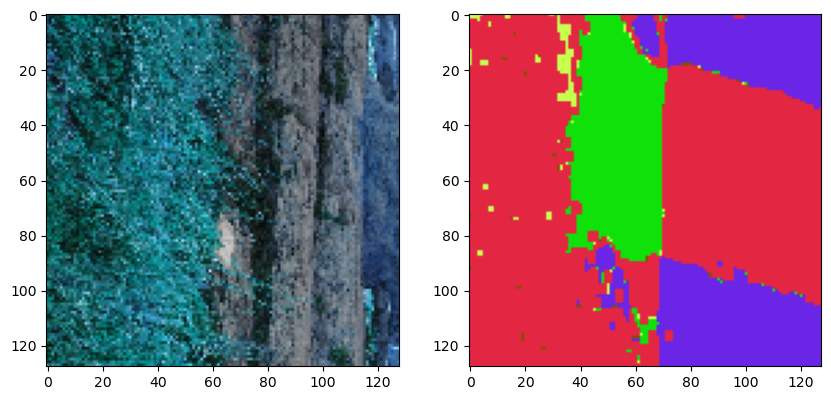

In [75]:
n=0
mask=mask_dataset[n]
# mask= np.repeat(mask[:, :, np.newaxis], 3, axis=2)
fig, axs = plt.subplots(1, 2,figsize=(10, 10))
fig.set_facecolor("white")
axs[0].imshow(tf.keras.utils.array_to_img(image_dataset[n]))
# axs[1].imshow(tf.keras.utils.array_to_img(mask))
axs[1].imshow(tf.keras.utils.array_to_img(np.array([*dic.values()])[mask]))
plt.show()

devide in training and testing samples

In [14]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
print(X_train.shape) # -> 80%
print(X_test.shape) # -> 20%

(64, 128, 128, 3)
(17, 128, 128, 3)


In [15]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes) # convert labels into channels
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
print(y_train_cat.shape) # -> 80%
print(y_test_cat.shape) # -> 20%

(64, 128, 128, 11)
(17, 128, 128, 11)


(test) turn it into a tf dataset

In [91]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat, weights))


ValueError: Dimensions 64 and 11 are not compatible

 (optional) In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.

In [5]:
# def normalize(input_image, input_mask):
#   input_image = tf.cast(input_image, tf.float32) / 255.0
#   # input_mask -= 1
#   return input_image, input_mask

In [7]:
# def load_image(datapoint):
#   input_image = tf.image.resize(datapoint['image'], (128, 128))
#   input_mask = tf.image.resize(
#     datapoint['segmentation_mask'],
#     (128, 128),
#     method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
#   )

#   input_image, input_mask = normalize(input_image, input_mask)

#   return input_image, input_mask

(optional) The dataset already contains the required training and test splits, so continue to use the same splits:

In [45]:
# TRAIN_LENGTH = y_train_cat.shape[0]#9info.splits['train'].num_examples
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [2]:
# train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
# test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.


In [26]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

(optional) Build the input pipeline, applying the augmentation after batching the inputs:

In [ ]:
#MB
# dataset = tf.data.Dataset.from_tensor_slices(images).batch(BATCH_SIZE)

In [27]:
# train_images=y_train_cat
# test_images=y_test_cat


In [1]:
# train_batches = (
#     train_images
#     .cache()
#     .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE)
#     .repeat()
#     .map(Augment())
#     .prefetch(buffer_size=tf.data.AUTOTUNE))

# test_batches = test_images.batch(BATCH_SIZE)

(optional) Visualize an image example and its corresponding mask from the dataset:

In [17]:
# def display(display_list):
#   plt.figure(figsize=(15, 15))

#   title = ['Input Image', 'True Mask', 'Predicted Mask']

#   for i in range(len(display_list)):
#     plt.subplot(1, len(display_list), i+1)
#     plt.title(title[i])
#     plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
#     plt.axis('off')
#   plt.show()

In [16]:
# display([images[0], masks[1]])

In [57]:
# for images, masks in train_batches.take(2):
#   sample_image, sample_mask = images[0], masks[0]
#   display([sample_image, sample_mask])

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)


As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [19]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model. 

Since this is a multiclass classification problem, use the `tf.keras.losses.CategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [27]:
#MB
model = unet_model(output_channels=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# model = unet_model(output_channels=n_classes)
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

Try out the model to check what it predicts before training:

In [33]:
# def create_mask(pred_mask):
#   pred_mask = tf.math.argmax(pred_mask, axis=-1) # this compresses the categorical channels back into 1 array
#   pred_mask = pred_mask[..., tf.newaxis]
#   return pred_mask[0]

In [45]:
# def show_predictions(image,mask):
#       print(image.shape)
#       pred_mask = model.predict(image)
#       display([image, mask, create_mask(pred_mask)])

The callback defined below is used to observe how the model improves while it is training:

In [101]:
import math
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

class_weight=create_class_weight(class_weights)

In [103]:
model_history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)
# class_weight = {0:2.0, 1:2.0, 2:1.0} # -> optional add weights -> this doesn't work with images as the dimensions don't fit will

Epoch 1/50
4/4 [==============================] - 1s 219ms/step - loss: nan - accuracy: 0.6358 - val_loss: nan - val_accuracy: 0.5842
Epoch 2/50
4/4 [==============================] - 1s 164ms/step - loss: nan - accuracy: 0.6358 - val_loss: nan - val_accuracy: 0.5842
Epoch 3/50
4/4 [==============================] - 1s 165ms/step - loss: nan - accuracy: 0.6358 - val_loss: nan - val_accuracy: 0.5842
Epoch 4/50
4/4 [==============================] - 1s 163ms/step - loss: nan - accuracy: 0.6358 - val_loss: nan - val_accuracy: 0.5842
Epoch 5/50
4/4 [==============================] - 1s 172ms/step - loss: nan - accuracy: 0.6358 - val_loss: nan - val_accuracy: 0.5842
Epoch 6/50
4/4 [==============================] - 1s 167ms/step - loss: nan - accuracy: 0.6358 - val_loss: nan - val_accuracy: 0.5842
Epoch 7/50
4/4 [==============================] - 1s 164ms/step - loss: nan - accuracy: 0.6358 - val_loss: nan - val_accuracy: 0.5842
Epoch 8/50
4/4 [==============================] - 1s 169ms/ste

In [23]:
# EPOCHS = 20
# VAL_SUBSPLITS = 5
# VALIDATION_STEPS = len(image_dataset)//BATCH_SIZE//VAL_SUBSPLITS

# model_history = model.fit(train_batches, epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=VALIDATION_STEPS,
#                           validation_data=test_batches,
#                           callbacks=[DisplayCallback()])

In [104]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3) # find max value in channels of the categorical and compress it back into 1 channel
y_pred_argmax.shape

1/1 [==============================] - 0s 50ms/step


(17, 128, 128)

[[162713      0      0      0      0      0      0      0      0      0]
 [  7651      0      0      0      0      0      0      0      0      0]
 [  5299      0      0      0      0      0      0      0      0      0]
 [ 11771      0      0      0      0      0      0      0      0      0]
 [ 75322      0      0      0      0      0      0      0      0      0]
 [   278      0      0      0      0      0      0      0      0      0]
 [  8386      0      0      0      0      0      0      0      0      0]
 [  5819      0      0      0      0      0      0      0      0      0]
 [  1284      0      0      0      0      0      0      0      0      0]
 [     5      0      0      0      0      0      0      0      0      0]]


AttributeError: module 'pandas' has no attribute 'DataFrame'

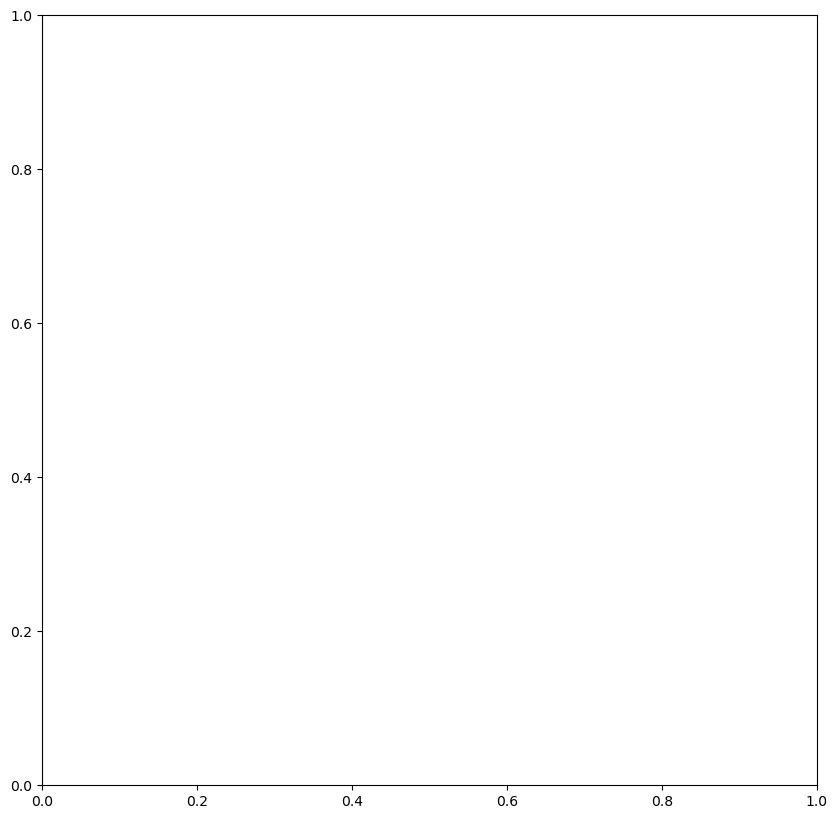

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(np.reshape(y_test[:,:,:,0],(-1,1)), np.reshape(y_pred_argmax,(-1,1)))
print(cf_matrix)
fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(cf_matrix, annot=True)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

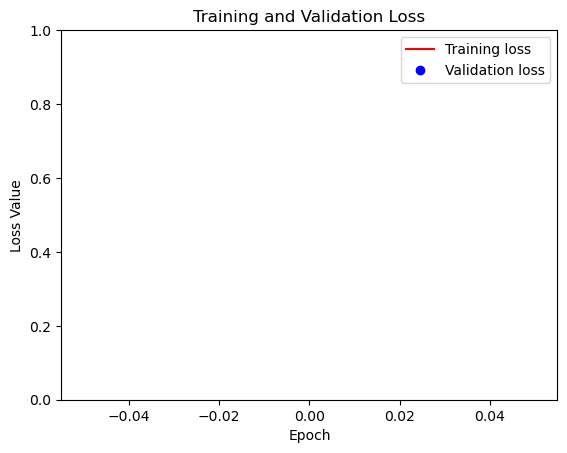

In [31]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [47]:
y_pred=model.predict(X_test)
print(y_test[:,:,:,0].shape)
print(y_pred.shape)


1/1 [==============================] - 2s 2s/step
(17, 128, 128)
(17, 128, 128, 11)


In [48]:
y_pred_argmax=np.argmax(y_pred, axis=3) # find max value in channels of the categorical and compress it back into 1 channel
y_pred_argmax.shape

(17, 128, 128)

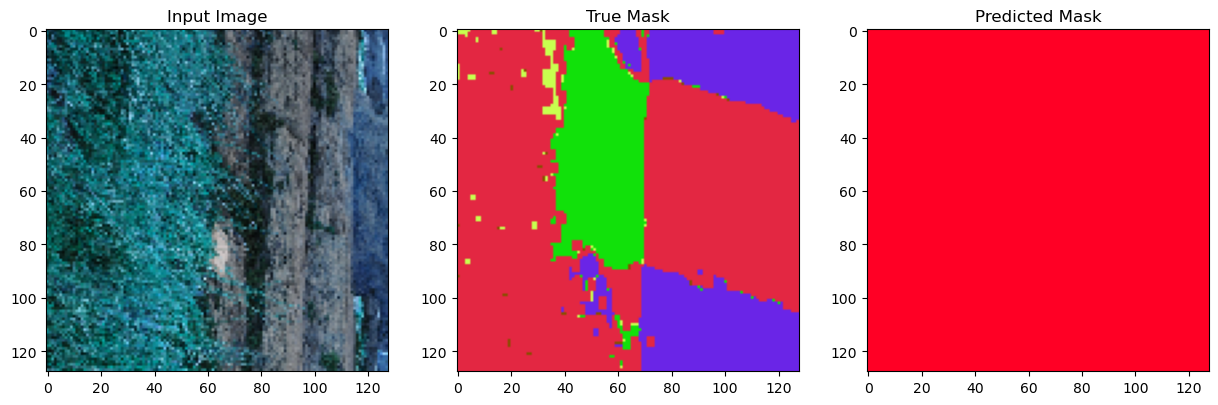

In [83]:
n=0
mask_gt=mask_dataset[n]
mask_pred=y_pred_argmax[n]

# mask= np.repeat(mask[:, :, np.newaxis], 3, axis=2)
fig, axs = plt.subplots(1, 3,figsize=(15, 15))
fig.set_facecolor("white")
axs[0].set_title('Input Image')
axs[0].imshow(tf.keras.utils.array_to_img(image_dataset[n]))
axs[1].set_title('True Mask')
axs[1].imshow(tf.keras.utils.array_to_img(np.array([*dic.values()])[mask_gt]))
axs[2].set_title('Predicted Mask')
axs[2].imshow(tf.keras.utils.array_to_img(np.array([*dic.values()])[mask_pred]))
plt.show()

## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.

In [26]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

In [27]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple. Where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [28]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [29]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Now, you can train a model on this weighted dataset:

In [30]:
weighted_model = unet_model(n_classes)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [31]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)


 1/10 [==>...........................] - ETA: 38s - loss: 0.4984 - accuracy: 0.3116


 2/10 [=====>........................] - ETA: 0s - loss: 0.4457 - accuracy: 0.3970 


 3/10 [========>.....................] - ETA: 0s - loss: 0.4043 - accuracy: 0.4626


 4/10 [===========>..................] - ETA: 0s - loss: 0.3768 - accuracy: 0.5043


 5/10 [==============>...............] - ETA: 0s - loss: 0.3510 - accuracy: 0.5443


 6/10 [=================>............] - ETA: 0s - loss: 0.3318 - accuracy: 0.5704


 7/10 [====================>.........] - ETA: 0s - loss: 0.3152 - accuracy: 0.5929


 8/10 [=======================>......] - ETA: 0s - loss: 0.2996 - accuracy: 0.6164


 9/10 [==========================>...] - ETA: 0s - loss: 0.2881 - accuracy: 0.6317


10/10 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.6478


10/10 [==============================] - 5s 70ms/step - loss: 0.2775 - accuracy: 0.6478


## Next steps

Now that you have an understanding of what image segmentation is and how it works, you can try this tutorial out with different intermediate layer outputs, or even different pretrained models. You may also challenge yourself by trying out the [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) image masking challenge hosted on Kaggle.

You may also want to see the [Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) for another model you can retrain on your own data. Pretrained models are available on [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional)